## Purpose of detecting heartbeat data

Our Midi Meditation project is a physical computing device that will repeatedly play a single note in sync with the user's heartbeat. Fundamental to this is the ability to reliably detect when a user's heart is beating.

We want our device to work effectively for most or all people. This means it should play one note in sync with the user's pulse without extra notes between beats.

We had a pulse sensor suitable for an Arduino to use for this project. One approach for prototyping this is to code a heartbeat detection algorithm on an Arduino after viewing the sensor readings on the Serial monitor for a couple of people. This approach could work but would require a lot of parameter tweaking to get it "just right" with repeated user testing between parameter adjustments.

<!-- TEASER_END -->

A better approach is to extract the sensor data from the Arduino and analyze it in Python. We can then experiment with various heartbeat detection algorithms in Python and find one that is simple and effective. Then we can code the Arduino one time with a good idea how effective the algorithm will be in the device. This will save us a lot of time and help us avoid repeatedly fiddling with the code and testing. This approach is also more reliable and we will get better results.

## Data Collection

First we need to collect pulse data from the Arduino using the pulse sensor. Our final version was going to have clear tape across the sensor and be attached to the user's finger using velcro. We collected data after configuring the sensor in this way because it might alter the sensor readings.

The code we put on the Arduino is below. The only thing it does is get a sensor reading once a millisecond and write it to the Serial port.

```c
void setup() {
  Serial.begin(500000);
  waitForSignal();
}

void waitForSignal() {
  digitalWrite(LED_BUILTIN, HIGH);

  while (Serial.available() == 0) {
    delay(25);
  }

  digitalWrite(LED_BUILTIN, LOW);
}

void loop() {
  long t = micros();

  int val = analogRead(A0);

  Serial.write((byte) (val >> 8));
  Serial.write((byte) val);

  // ensure readings happen once a millisecond
  delayMicroseconds(1000 - (t % 1000));
}
```

We wanted to be precise with our readings and measure once a millisecond. To do this we need a delay in the `loop` function that considers execution time of the function itself. Previously I did performance testing of an Arduino and I know that an `analogRead` call takes about 112 microseconds. Sending a single byte over the Serial port takes about $$\frac{9900}{b}$$ milliseconds, where `b` is the Serial baud rate. In this case sending the two bytes takes about 40 microseconds. The execution time of the loop is less than a millisecond.

The Arduino is configured to wait until we are ready to collect data before it takes any sensor readings and sends data. This is to ensure it does not fill up the Serial buffer with nonsense values before we properly attach the pulse sensor to someone's finger.

In Python we collect the data and write it to a file using PySerial.

```python
ser = serial.Serial('/dev/ttyACM0', 500000)
ser.write(bytes(1))
raw_bytes = ser.read(30 * 1000 * 2) # 30 seconds * 1000 readings per second * 2 bytes per reading

pulse_readings = DataFrame(np.fromstring(raw_bytes, dtype='>u2'), columns=['reading']).astype(np.int)
pulse_readings.to_pickle('data/pulse_data_2017.10.20_{0}.p'.format(name))
```

Our data collection was successful. We collected data for ourselves and for a couple of classmates.

The above data collection code sometimes will mangle the bytes. I suspect that the Serial baud rate was too fast for the Arduino and the timing got messed up. Also, we are sending two bytes so we get the full range of 0 to 1023. The bytes as recieved by Python needs to be interpretted as an `unsigned int`. I could have divided the sensor reading by 4 and send the data as a single byte. Getting this to work with two bytes was time consuming and probably more trouble than it is worth. Still, I am happy I did it and will experiment with it more in the future.

## Visualize data

After collecting the data, the next step is to visualize it to see what we are dealing with. Our charts are below.

In [1]:
import pandas as pd
from pandas import DataFrame
from pandas_datareader import data
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

font = {'family' : 'DejaVu Sans', 'weight' : 'bold', 'size' : 22}

matplotlib.rc('font', **font)

In [2]:
def make_plot(name):
    pulse_readings = pd.read_pickle('data/pulse_data_2017.10.20_{0}.p'.format(name))
    pulse_readings.plot(figsize=(12, 8), legend=False, color=['k'])

    plt.grid(True)
    plt.ylim([0, 1023])
    plt.title('Pulse readings for {0} taken on 2017.10.20'.format(name))

First we took readings for ourselves.

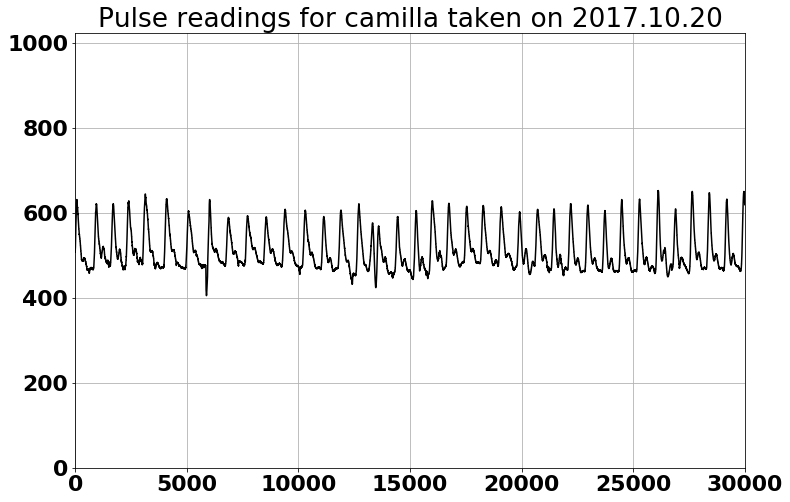

In [3]:
make_plot('camilla')

Notice how the second reading for Camilla was more uneven.

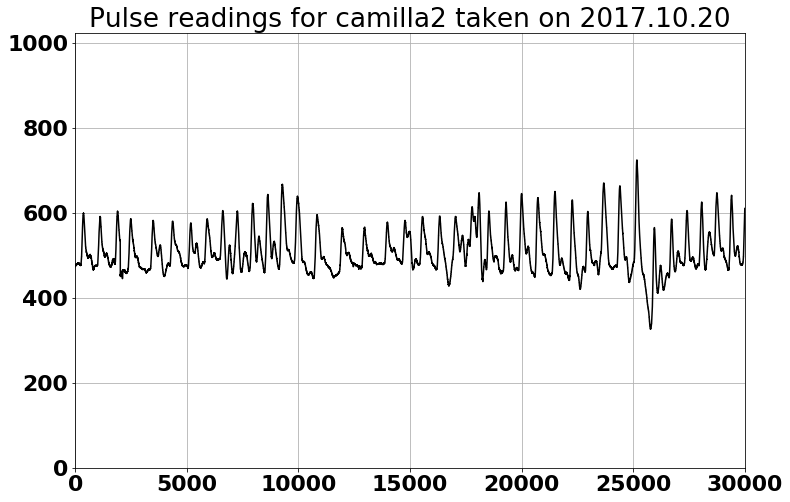

In [4]:
make_plot('camilla2')

Readings for myself (Jim) had a larger range. There is also a very noticeable second pulse after the main pulse. This second spike should be ignored by our application.

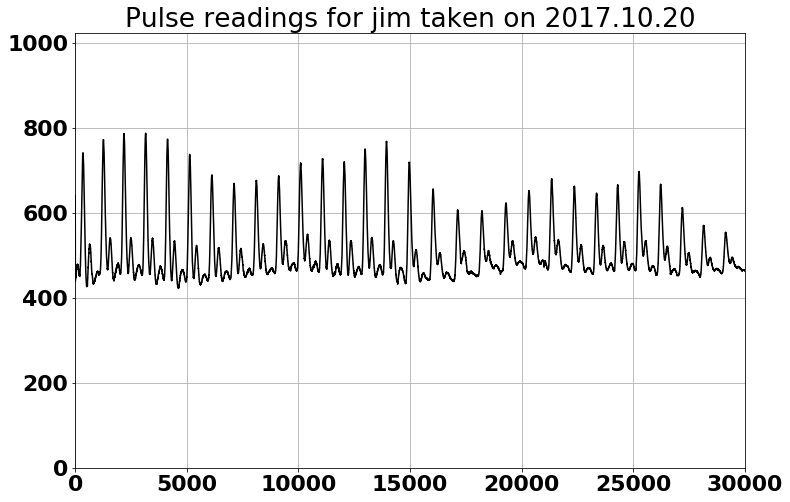

In [5]:
make_plot('jim')

The second reading for myself had an even larger range. Also notice the bottom range of the readings is a bit lower than the previous charts.

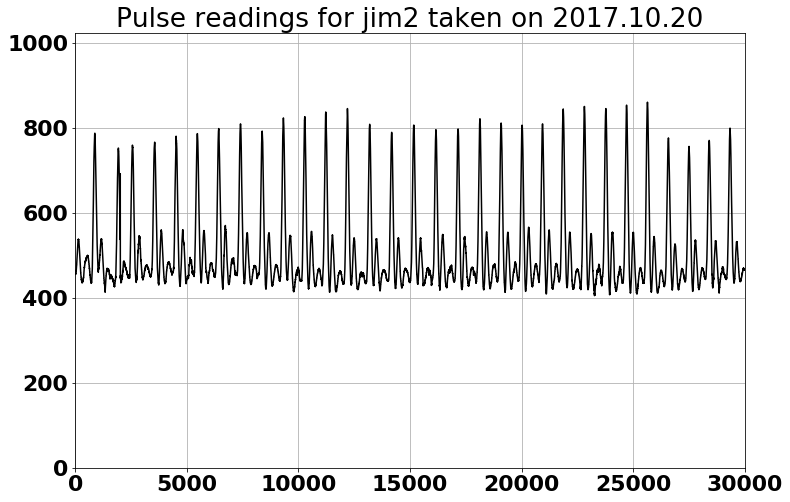

In [6]:
make_plot('jim2')

Our fellow ITP student Alan also let us do some readings. These measurements are more chaotic.

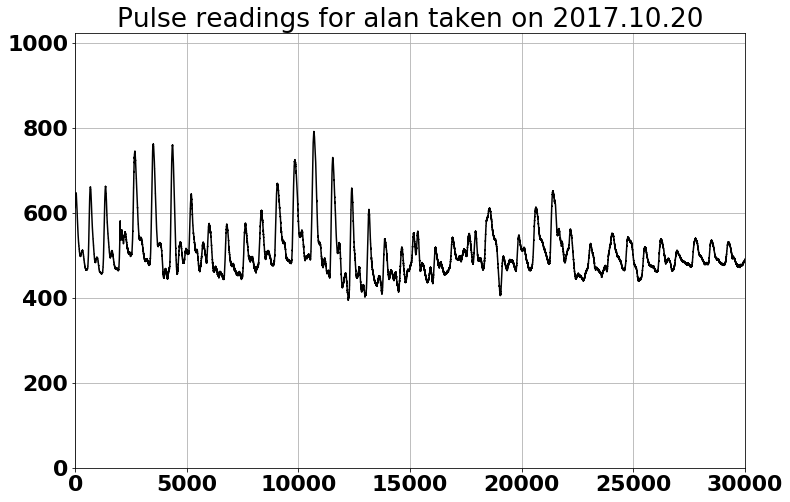

In [7]:
make_plot('alan')

Roland's readings were much more subdued. The range is much more limited.

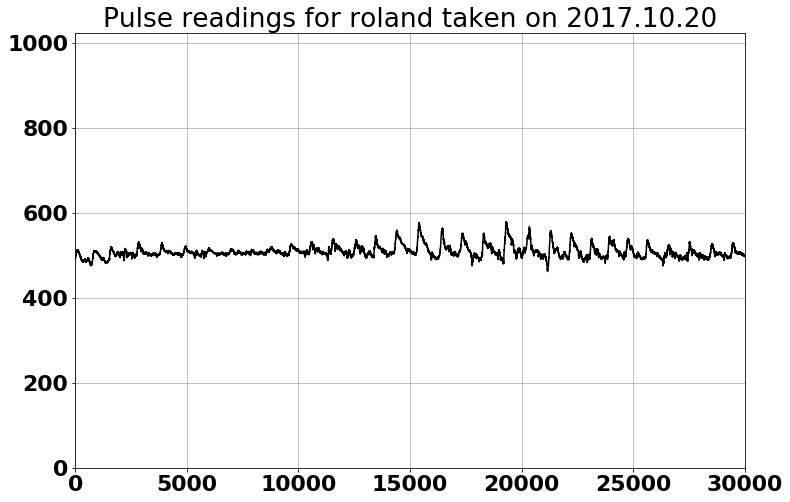

In [8]:
make_plot('roland')

MH had nice even readings. Also observe his pulse rate is much higher than anyone else.

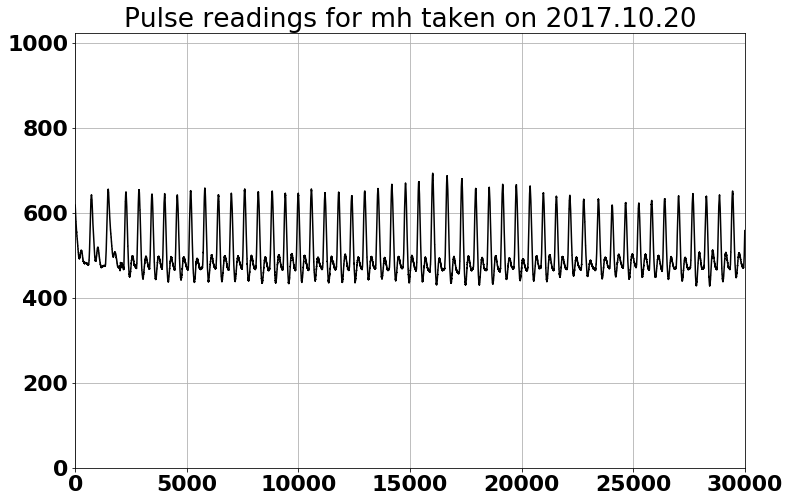

In [9]:
make_plot('mh')

Many thanks to Roland, Alan, and MH for providing their data.

# How to detect heartbeats

Our first attempt at finding a heartbeat attempted to identify peaks by comparing changes in readings from one measurement to the next. If we could identify when the sensor readings switch from ascending to descending, we would detect beats.

Unfortunately this worked very poorly, and we didn't see why until after we pulled the data off the Arduino. The sensor readings are noisy and contain many peaks and valleys when observed at the small scale.

Observe the below chart of Camilla's data for 200 milliseconds. The noisy data can trip up an algorithm that is looking for peaks in the readings.

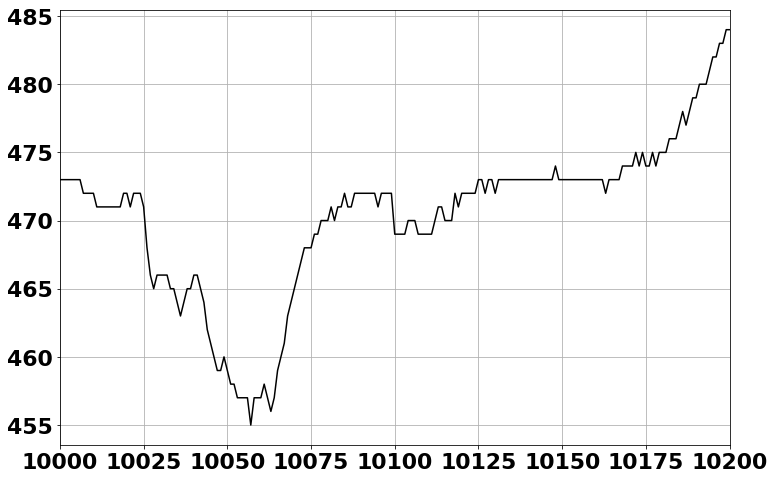

In [10]:
pulse_readings = pd.read_pickle('data/pulse_data_2017.10.20_camilla.p').loc[10000:10200]
pulse_readings.plot(figsize=(12, 8), legend=False, color=['k'])

plt.grid(True)

Our second attempt to code this involved observing when the sensor reading rose above a single, fixed threshold. This approach is acceptable but the question is where to put that threshold.

Camilla's data suggests the threshold needs to be under 600.

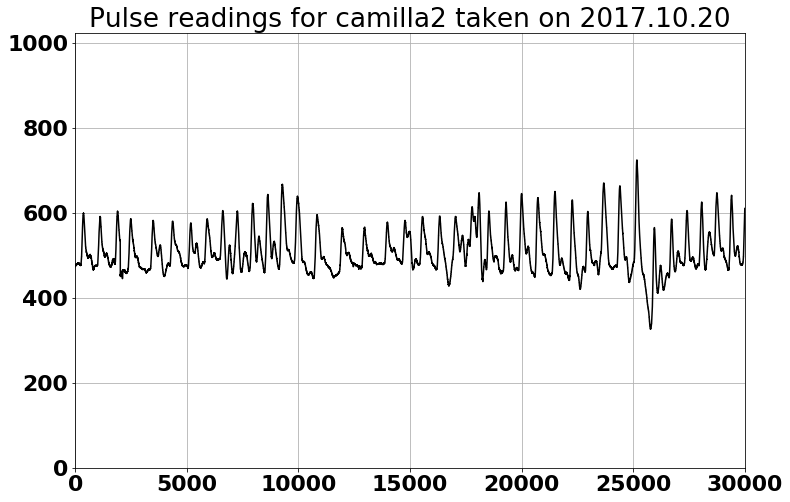

In [11]:
make_plot('camilla2')

But my data shows that something too far below 600 would result in false pulse readings.

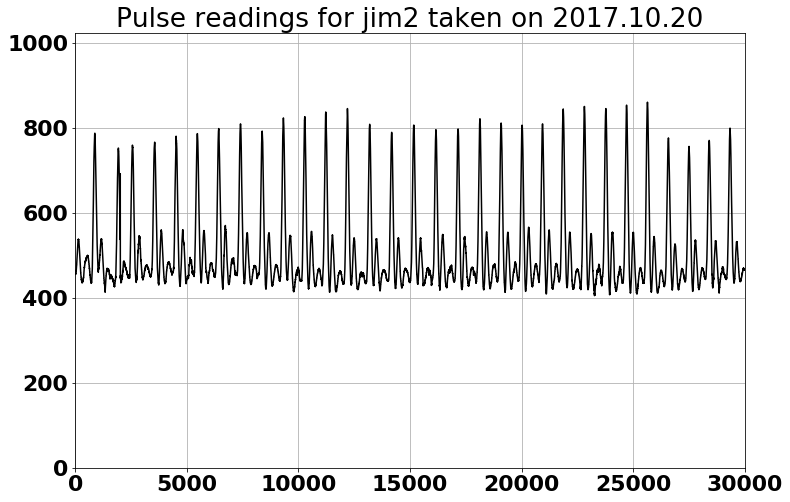

In [12]:
make_plot('jim2')

There seems to be a narrow band within which this will work for both of us. We could fiddle with it to find that level, but any level we do find will be fragile. If something is a little bit "off" with the sensor or our fingers on Wednesday (when we are presenting this project) the pulse detection might not work at all. And no level will properly work for the other people we collected data for.

### Moving Averages

The approach we used is to employ moving averages. This approach is inspired by their use with financial data.

In [13]:
stock_data = data.get_data_yahoo('IBM', start='1/1/2014', end='10/23/2017')

Below is some historical price data for a large company. A trading strategy that people might actually employ is to compare the current price with the moving averages and buy or sell when then the price moves above or below a moving average. 

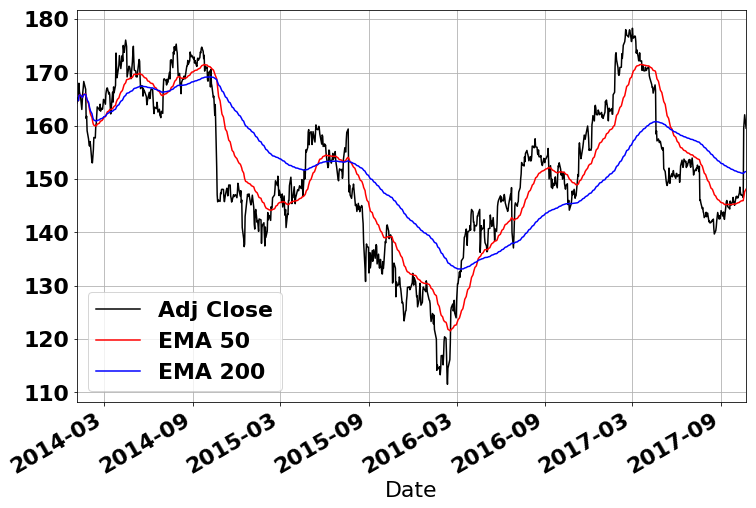

In [14]:
stock_data['EMA 200'] = stock_data['Adj Close'].ewm(span=200).mean()
stock_data['EMA 50'] = stock_data['Adj Close'].ewm(span=50).mean()

stock_data[['Adj Close', 'EMA 50', 'EMA 200']].plot(figsize=(12, 8), legend=True, color=['k', 'r', 'b'])
plt.grid(True)

That's great, but what exactly is a moving average, and why is it used?

A moving average smoothes out the values, eliminating the small, short term changes but keeping the longer and persistent changes. The main idea here is to identify times when the stock price is taking off or dropping but ignoring the smaller and inconsequential price movements. 

This would be useful for our goal of detecting a user's pulse. It could detect a large spike in sensor readings but ignore the smaller ones.

There are different kinds of moving averages. There are moving averages with a fixed window, called rolling averages, and there are exponential moving averages. Implementation of a rolling average would require our code to maintain a history of previous values which would take up some of the Arduino's limited memory. A simpler approach would be to use an exponential moving average. The formula for this is simple.

\begin{equation}
  ema_{t} = a \cdot x_{t} + (1 - a) \cdot ema_{t-1}
\end{equation}

Or maybe confusing to people who are not used to equations. Instead, consider an example.

At time zero, the exponential moving average starts out at 0.0. If our first reading is 1.0, the next moving average value is a weighted average of the previous moving average value and the new observation.

\begin{equation}
  0.01 = 0.01 \cdot 1.0 + 0.99 \cdot 0.0
\end{equation}

This can be repeated for the second reading, also 1.0. The previously calculated moving average feeds back into the calculation for the new moving average.

\begin{equation}
  0.0199 = 0.01 \cdot 1.0 + 0.99 \cdot 0.01
\end{equation}

And a third reading:

\begin{equation}
  0.0297 = 0.01 \cdot 1.0 + 0.99 \cdot 0.0199
\end{equation}

This can be repeated again and again. The moving average will continue to increase, and eventually, it will "catch up" to the current reading value of 1.0.

The below example shows what the exponential moving average looks like when the readings switch between 0 and 1 every 200 steps. The moving average reacts to large changes in the value but is slow to fully adapt.

(0, 1.5)

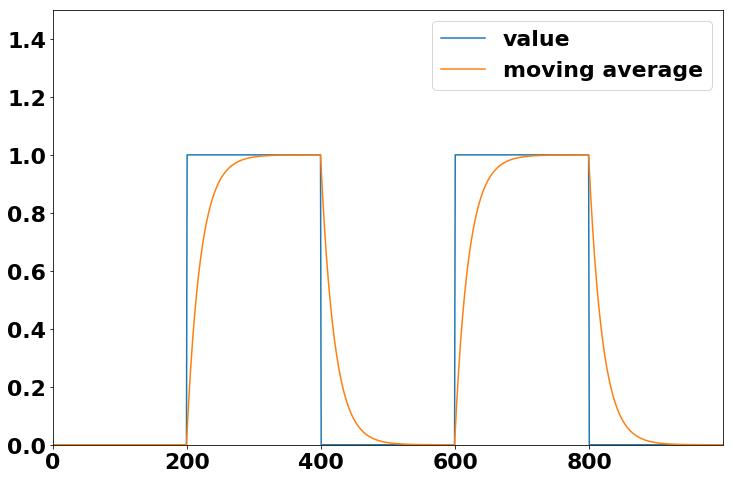

In [15]:
test_ema = DataFrame(index=range(1000))
test_ema['value'] = 0
test_ema.iloc[test_ema.index // 200 % 2 == 1] = 1
test_ema['moving average'] = test_ema['value'].ewm(20).mean()

test_ema.plot(figsize=(12, 8), legend=True)

plt.ylim([0, 1.5])

If we add a small amount of noise the moving average is barely affected.

(0, 1.5)

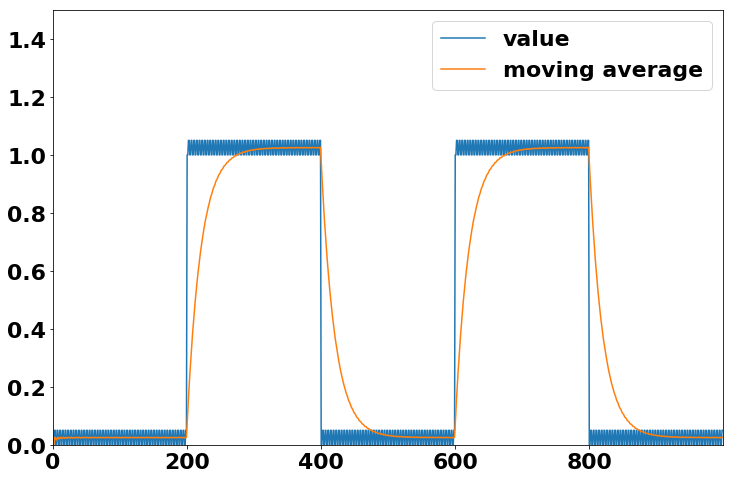

In [16]:
test_ema.iloc[test_ema.index // 2 % 2 == 1] += 0.05

test_ema['moving average'] = test_ema['value'].ewm(20).mean()

test_ema.plot(figsize=(12, 8), legend=True)

plt.ylim([0, 1.5])

We can calculate the moving average for our pulse data and use it to detect the user's pulse. In these charts, we are detecting a pulse when the current reading is 60 more than the moving average.

In [17]:
def make_plot_with_pulse_detection(name, span=3000, threshold=60):
    pulse_readings = pd.read_pickle('data/pulse_data_2017.10.20_{0}.p'.format(name))
    pulse_readings['ema'] = pulse_readings['reading'].ewm(span=span).mean()
    pulse_readings['heartbeat'] = pulse_readings['reading'].where(pulse_readings.eval('reading > ema + @threshold'))

    pulse_readings.plot(figsize=(12, 8), legend=False, color=['k', 'b', 'r'])

    plt.grid(True)
    plt.ylim([0, 1023])
    plt.legend(['pulse reading', 'moving average', 'detected heartbeat'])
    plt.title('Pulse detection for {0}'.format(name))

Our code seems to do a good job detecting Camilla's heartbeat.

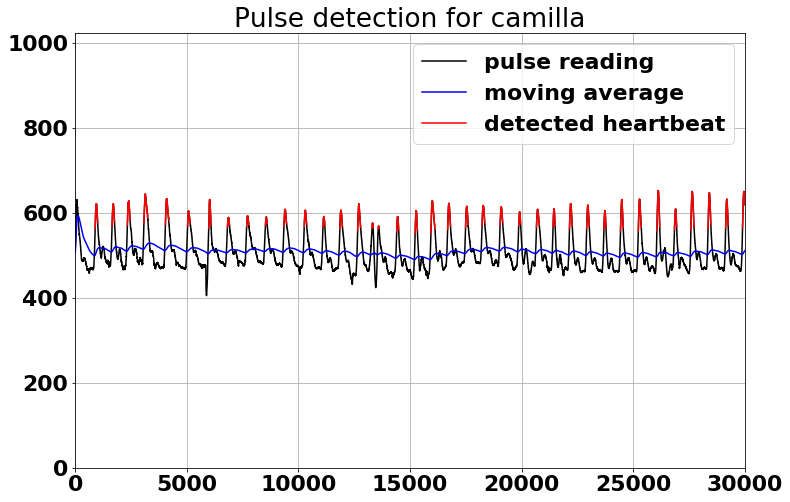

In [18]:
make_plot_with_pulse_detection('camilla')

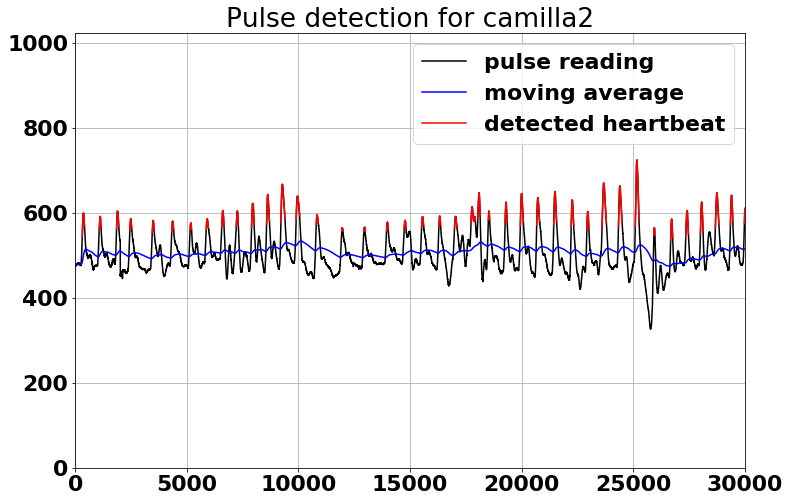

In [19]:
make_plot_with_pulse_detection('camilla2')

It also does a good job detecting mine.

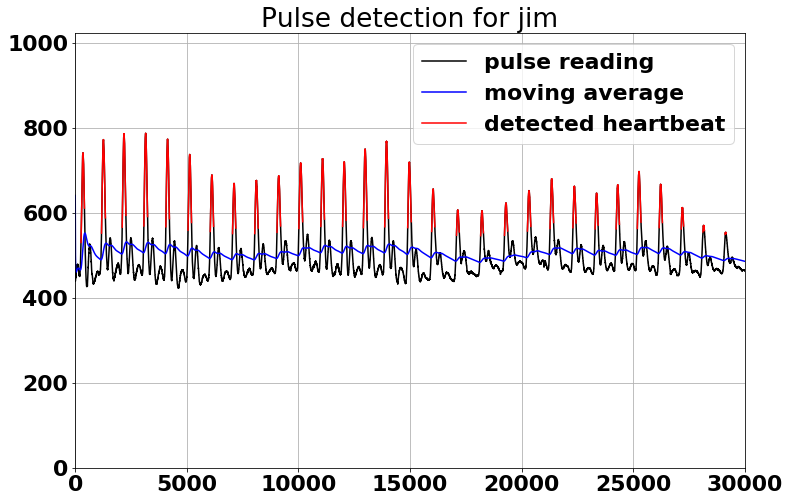

In [20]:
make_plot_with_pulse_detection('jim')

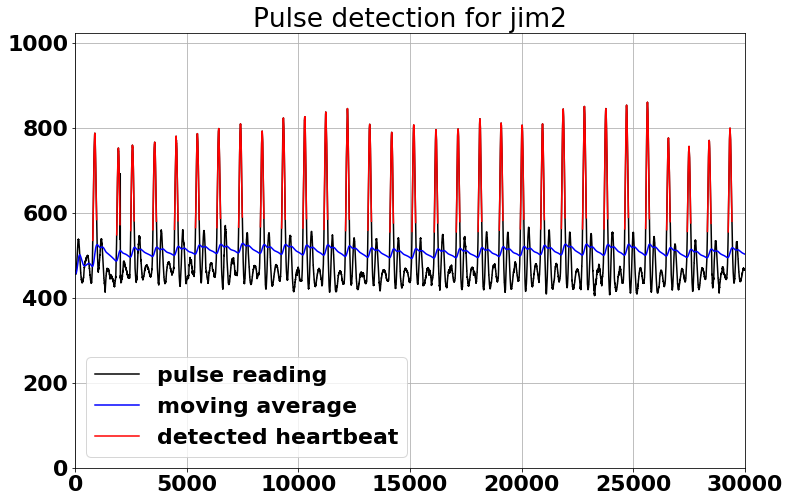

In [21]:
make_plot_with_pulse_detection('jim2')

It works reasonably well for Alan. Notice the moving average is moving up and down quite a bit. This means the value the current reading is being compared to is changing, making it possible to detect some pulses when the signal changes noticeably. This wouldn't happen with a fixed threshold. 

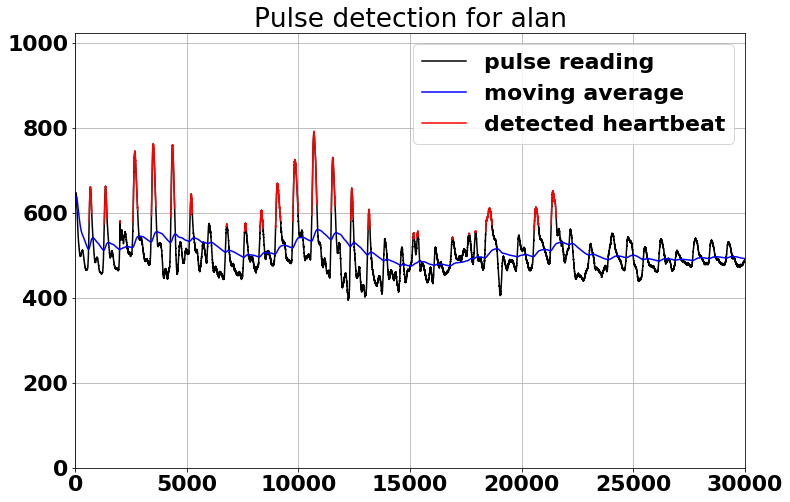

In [22]:
make_plot_with_pulse_detection('alan')

Pulse detection works effectively for MH.

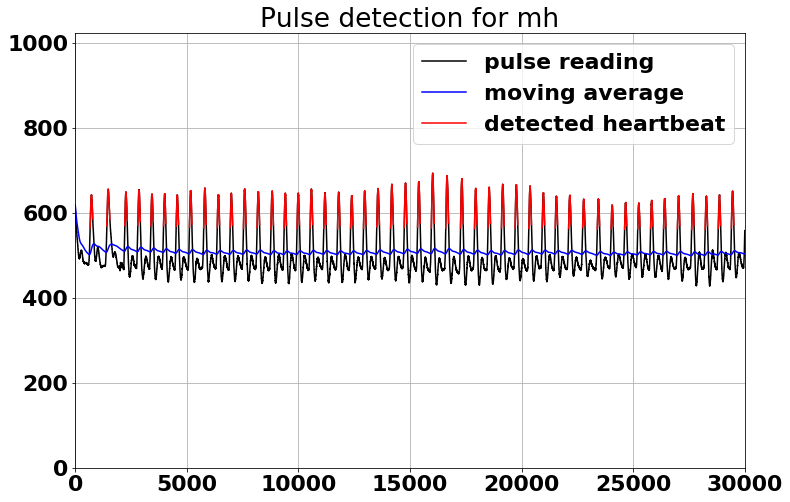

In [23]:
make_plot_with_pulse_detection('mh')

Detecting Roland's pulse still doesn't work, unfortunately. Nevertheless it is good to know the limitations of our pulse detection. It will not work for everyone.

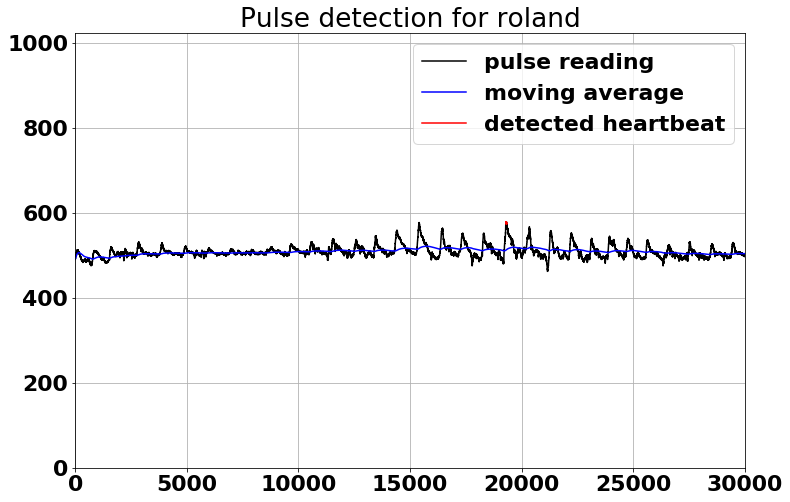

In [24]:
make_plot_with_pulse_detection('roland')

## Further improvements

Our approach of collecting data and analyzing it separately from the actual physical device was very effective. It allows us to answer questions about how well our pulse detection would work for different parameter settings without having to retest on every person. We can adjust it to work for person B without worrying about breaking it for person A.

There are some things we could do to make this work better for Roland and other people with weak pulse measurements. Instead of detecting a pulse when the current reading is a fixed value above the moving average, we could measure the rolling volatility. This would effectively "scale" the threshold to accomodate the range of variations of people's measurements. Something like this would work for Roland without also breaking pulse detection for everyone else. This improvements would be interesting to pursue but this is a Physical Computing class and we should focus on the interaction and the electronics. This isn't a signal processing class and we don't want to make this overly complicated.

Finally, it would be helpful to quantitatively measure the accuracy of different algorithms to more accurately compare the default algorithm approach of a fixed threshold with our approach with moving averages or other approaches. These statistical techniques are overkill for this project but could and should be used if this product were to advance beyond the prototype stage.